# **Decision Tree**

Decision tree is like a flow chart with decision, arrow and terminal. The terminal is the class for classification and predicted value for regression. 
<img src="img/decision_tree.png" width="600">

One key for the decision tree is how to decide a good split point. With a good split, the groups after sjplitting should have small intra-differnce and relative large inter-difference.
Here two index can measure the randomness of data: **entropy** and **gini**
  
<img src="img/decision_tree_entropy.png" width="600">

#### **entropy**
$$H(x)=-\Sigma_{i}^{n}P(x_i)\text{log}_{2}P(x_i)$$

$\Sigma_{i}^{n}$ is the pbability of event, $\text{log}_{2}P(x_i)$ represents the amount of information coming from the event.

As there is the minus sign, so the lower the entropy, the more information delivered.


To proof this, assumed that there are 2 groups A abd B, obviously can see that A group has higher purity than B.

Let's calculate the entropy for these two groups.  
  
$H_A = \frac{24}{30}\text{log}_{2}\frac{24}{30} + \frac{6}{30}\text{log}_{2}\frac{6}{30}=0.72$
  
$H_B = \frac{15}{30}\text{log}_{2}\frac{15}{30} + \frac{15}{30}\text{log}_{2}\frac{15}{30}=1$

#### **gini**
$$G(x) = 1 - \Sigma_{i}^{n}P(x_i)^2$$
  
Let use the same example group A anf group B to calculate gini.

$$G_A = 1 - ((\frac{24}{30})^2+(\frac{6}{30})^2) = 0.32$$
$$G_B = 1 - ((\frac{15}{30})^2+(\frac{15}{30})^2) = 0.5$$

The same as entropy, A has lower value than B, so the lower the gini, the higher the purity.
 
As a result, we need to find a split can get lower entropy or entropy.

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np

# load iris dataset
iris = datasets.load_iris()
X=np.array(iris.data)
y = np.array(iris.target)

In [2]:
def entropy(class_probabilitues: list) -> float:
    """Implement the entropy function
    Args:
        class_probabilitues (list): A list of class probabilities
    Returns:
        entropy (float): The entropy of the given class probabilities"""
    return sum([-p * np.log2(p+1e-10) for p in class_probabilitues])

def gini(class_probabilities: list) -> float:
    """Implement the gini function
    Args:
        class_probabilities (list): A list of class probabilities
    Returns:
        gini (float): The gini of the given class probabilities"""
    return 1 - sum([p**2 for p in class_probabilities])

In [3]:
from typing import Tuple
def split(X: np.array, y: np.array, feature_idx: int, feature_val: float) -> Tuple[np.array, np.array]:
    """Split the data into two group with the given feature and value
    Args:
        X (np.array): The input data
        y (np.array): The target labels
        feature_idx (int): The index of the feature to split
        feature_val (float): The value to split on
    Returns:
        x1 (np.array): left data
        x2 (np.array): right data
        y1 (np.array): left labels
        y2 (np.array): right labels
        p1 (np.array): The probability of each class in the left split data
        p2 (np.array): The probability of each class in the right split data"""
    x1 = X[X.T[feature_idx]<feature_val]
    x2 = X[X.T[feature_idx]>=feature_val]
    y1 = y[X.T[feature_idx]<feature_val]
    y2 = y[X.T[feature_idx]>=feature_val]
    n_classes = len(np.unique(y))

    if len(y1) == 0:
        p1 = [0]*n_classes
    else:
        p1 = [np.sum(y1==c)/len(y1) for c in range(n_classes)]
    if len(y2) == 0:
        p2 = [0]*n_classes
    else:
        p2 = [np.sum(y2==c)/len(y2) for c in range(n_classes)]

    return x1, x2, y1, y2, p1, p2

In [4]:
def find_best_split(X, y, criterion):
    """Find the best split for the given data and criterion
    Args:
        X (np.array): The input data
        y (np.array): The target labels
        criterion (str): The criterion to use for finding the best split
    Returns:
        best_split (dict): The best split found by the algorithm"""
    n_features = X.shape[1]
    best_score = 10e+10
    flag = False
    for feature_idx in range(n_features):
        for feature_val in np.unique(X.T[feature_idx]):
            x1, x2, y1, y2, p1, p2 = split(X, y, feature_idx, feature_val)
            current_split = {'feature_idx': feature_idx, 'feature_val': feature_val, 
                              'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'best_score': best_score, 'p1': p1, 'p2': p2}
            if criterion == 'entropy':
                score = entropy(p1) + entropy(p2)
            elif criterion == 'gini':
                score = gini(p1) + gini(p2)
            if score < best_score:
                flag = True
                best_score = score
                best_split = current_split
    if flag:
        return best_split['feature_idx'], best_split['feature_val'], best_split['best_score'], \
                best_split['x1'], best_split['x2'], best_split['y1'], best_split['y2']
    else:
        return current_split['feature_idx'], current_split['feature_val'], current_split['best_score'], \
                current_split['x1'], current_split['x2'], current_split['y1'], current_split['y2']
        

In [5]:
#from treenode import TreeNode
total_nclasses = len(np.unique(y))
class TreeNode:
    def __init__(self, X, feature_idx, feature_val, label_probs, information_gain, parent = None):
        self.X = X
        self.feature_idx: int = feature_idx
        self.feature_val: float = feature_val
        self.label_probs: list = label_probs
        self.information_gain: float = information_gain
        self.parent: TreeNode = parent
        self.left: TreeNode = None
        self.right: TreeNode = None
    
    def update_left(self, left):
        self.left = left

    def update_right(self, right):
        self.right = right

def get_data_prob(y):
    """Get the probability of each class in the given data
    Args:
        y (np.array): The target labels
    Returns:
        label_probs (np.array): The probability of each class in the given data"""
    label_probs = np.zeros(total_nclasses, dtype = float)
    for label in range(total_nclasses):
        label_probs[label] = np.sum(y == label) / len(y)
    return label_probs


def build_tree(X, y, criterion, current_depth, max_depth=6, min_samples_leaf=1, parent = None):
    """Build a decision tree for the given data
    Args:
        X (np.array): The input data
        criterion (str): The criterion to use for finding the best split
        max_depth (int): The maximum depth of the tree
    Returns:
        root (TreeNode): The root node of the decision tree"""
    
    if current_depth > max_depth:
        return None
    
    feature_idx, feature_val, best_score, x1, x2, y1, y2 = find_best_split(X, y, criterion)
    label_probs = get_data_prob(y)
    if criterion == 'entropy':
        node_info = entropy(label_probs)
    elif criterion == 'gini':
        node_info = gini(label_probs)
    information_gain = node_info - best_score
    node = TreeNode(X, feature_idx, feature_val, label_probs, information_gain, parent)
    
    if len(x1) < min_samples_leaf or len(x2) < min_samples_leaf:
        return node
    #print(current_depth)
    current_depth += 1
    node.update_left(build_tree(x1, y1, criterion, current_depth, max_depth, parent = node))
    node.update_right(build_tree(x2, y2, criterion, current_depth, max_depth, parent = node))

    return node

In [6]:
tree = build_tree(X, y, 'entropy', 0, 3, 3)

In [7]:
def calculate_feature_importance(node):
    """Calculate the feature importance of the tree
    Args:
        node (TreeNode): The root node of the tree
    Returns:
        feature_importances (dict): The feature importance of the tree
    """
    if node is None:
        return
    if node.left is None and node.right is None:
        return
    if node.left is not None:
        feature_importances[node.feature_idx] += node.information_gain
        calculate_feature_importance(node.left)
    if node.right is not None:
        feature_importances[node.feature_idx] += node.information_gain
        calculate_feature_importance(node.right)
    return feature_importances
feature_importances = dict.fromkeys(range(X.shape[1]), 0)
feature_importances = calculate_feature_importance(tree)

In [8]:
Node = tree

def print_tree(Node, depth = 0):
    if Node is None:
        return
    print(' | '*depth,'-', Node.feature_idx, '<' , Node.feature_val)
    if Node.left is None and Node.right is None:
        print('   '*depth, '| - class: ', np.argmax(Node.label_probs))
    print_tree(Node.left, depth+1)
    print(' | '*depth,'-', Node.feature_idx, '>=' , Node.feature_val)
    if Node.left is None and Node.right is None:
        print('   '*depth, '| - class: ', np.argmax(Node.label_probs))
    print_tree(Node.right, depth+1)

print_tree(Node)

 - 2 < 3.0
 |  - 0 < 4.4
 |  |  - 0 < 4.3
       | - class:  0
 |  |  - 0 >= 4.3
       | - class:  0
 |  - 0 >= 4.4
 |  |  - 0 < 4.5
 |  |  |  - 1 < 3.0
          | - class:  0
 |  |  |  - 1 >= 3.0
          | - class:  0
 |  |  - 0 >= 4.5
 |  |  |  - 0 < 4.6
          | - class:  0
 |  |  |  - 0 >= 4.6
          | - class:  0
 - 2 >= 3.0
 |  - 3 < 1.8
 |  |  - 2 < 5.6
 |  |  |  - 0 < 4.9
          | - class:  1
 |  |  |  - 0 >= 4.9
          | - class:  1
 |  |  - 2 >= 5.6
 |  |  |  - 0 < 6.1
          | - class:  2
 |  |  |  - 0 >= 6.1
          | - class:  2
 |  - 3 >= 1.8
 |  |  - 0 < 5.6
       | - class:  2
 |  |  - 0 >= 5.6
       | - class:  2


In [9]:
def predict(X: np.array) -> np.array:
    """Predict the class of the given input data
    Args:
        X (np.array): The input data
    Returns:
        predictions (np.array): The predicted class of the input data"""
    predictions = []
    for x in X:
        node = tree
        while node.left is not None and node.right is not None:
            if x[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right
        predictions.append(np.argmax(node.label_probs))
    return np.array(predictions)
y_pred = predict(X)

Accuracy: 97 %


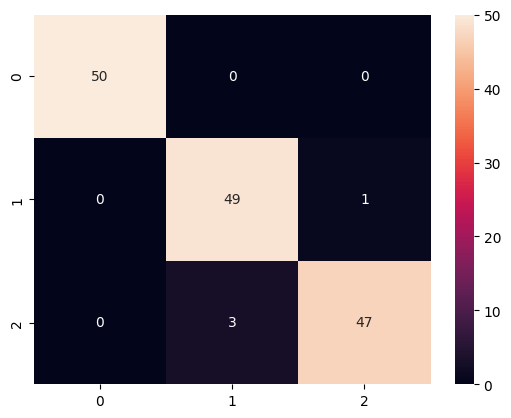

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y, y_pred)

sns.heatmap(cm, annot=True, annot_kws={"size": 10})


acc = np.sum(y==y_pred)/len(y_pred)
print("Accuracy: {} %".format(round(acc*100),2))

Accuracy: 93 %


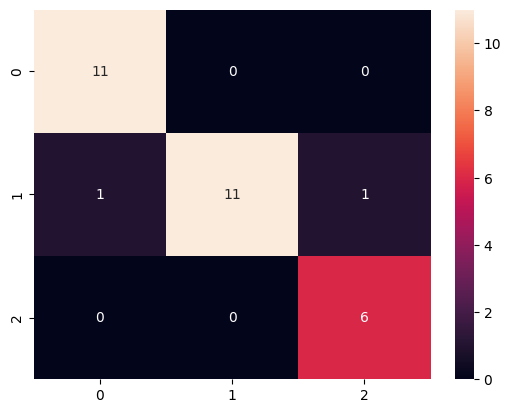

In [11]:
from sklearn.model_selection import train_test_split

X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

tree = build_tree(X_train, y_train, 'entropy', 0, 5, 3)
y_pred = predict(X_test)


cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, annot_kws={"size": 10})


acc = np.sum(y_test==y_pred)/len(y_pred)
print("Accuracy: {} %".format(round(acc*100),2))

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple
from sklearn.model_selection import train_test_split

class ClassificationTreeNode:
    def __init__(self, X, feature_idx, feature_val, label_probs, information_gain, parent = None):
        self.X = X
        self.feature_idx: int = feature_idx
        self.feature_val: float = feature_val
        self.label_probs: list = label_probs
        self.information_gain: float = information_gain
        self.parent: ClassificationTreeNode = parent
        self.left: ClassificationTreeNode = None
        self.right: ClassificationTreeNode = None
    
    def update_left(self, left):
        self.left = left

    def update_right(self, right):
        self.right = right

class DecisionTreeClassifier:
    def __init__(self, criterion: str = 'entropy', max_depth: int = 6, min_samples_leaf: int = 1):
        """
        Args:
            criterion (str): criterion to split the data
            max_depth (int): maximum depth of the tree
            min_samples_leaf (int): minimum number of samples required to be at a leaf node
        """
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree: DecisionTreeClassifier = None

    def update_left(self, left):
        self.left = left

    def update_right(self, right):
        self.right = right

    def entropy(self, class_probabilitues: list) -> float:
        """Implement the entropy function
        Args:
            class_probabilitues (list): A list of class probabilities
        Returns:
            entropy (float): The entropy of the given class probabilities"""
        return sum([-p * np.log2(p+1e-10) for p in class_probabilitues])

    def gini(self, class_probabilities: list) -> float:
        """Implement the gini function
        Args:
            class_probabilities (list): A list of class probabilities
        Returns:
            gini (float): The gini of the given class probabilities"""
        return 1 - sum([p**2 for p in class_probabilities])
    
    def split(self, X: np.array, y: np.array, feature_idx: int, feature_val: float) -> Tuple[np.array, np.array]:
        """Split the data into two group with the given feature and value
        Args:
            X (np.array): The input data
            y (np.array): The target labels
            feature_idx (int): The index of the feature to split
            feature_val (float): The value to split on
        Returns:
            x1 (np.array): left data
            x2 (np.array): right data
            y1 (np.array): left labels
            y2 (np.array): right labels
            p1 (np.array): The probability of each class in the left split data
            p2 (np.array): The probability of each class in the right split data"""
        x1 = X[X.T[feature_idx]<feature_val]
        x2 = X[X.T[feature_idx]>=feature_val]
        y1 = y[X.T[feature_idx]<feature_val]
        y2 = y[X.T[feature_idx]>=feature_val]
        n_classes = len(np.unique(y))

        if len(y1) == 0:
            p1 = [0]*n_classes
        else:
            p1 = [np.sum(y1==c)/len(y1) for c in range(n_classes)]
        if len(y2) == 0:
            p2 = [0]*n_classes
        else:
            p2 = [np.sum(y2==c)/len(y2) for c in range(n_classes)]

        return x1, x2, y1, y2, p1, p2

    def find_best_split(self, X: np.array, y: np.array) -> Tuple[int, float, float, np.array, np.array, np.array, np.array]:
        """Find the best split for the given data and criterion
        Args:
            X (np.array): The input data
            y (np.array): The target labels
        Returns:
            feature_idx (int): The index of the feature to split
            feature_val (float): The value to split on
            best_score (float): The best score of the split
            x1 (np.array): The left split data
            x2 (np.array): The right split data
            y1 (np.array): The left split target labels
            y2 (np.array): The right split target labels
            """
        n_features = X.shape[1]
        best_score = 10e+10
        flag = False
        for feature_idx in range(n_features):
            for feature_val in np.unique(X.T[feature_idx]):
                x1, x2, y1, y2, p1, p2 = self.split(X, y, feature_idx, feature_val)
                current_split = {'feature_idx': feature_idx, 'feature_val': feature_val, 
                                'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'best_score': best_score, 'p1': p1, 'p2': p2}
                if self.criterion == 'entropy':
                    score = self.entropy(p1) + self.entropy(p2)
                elif self.criterion == 'gini':
                    score = self.gini(p1) + self.gini(p2)
                if score < best_score:
                    flag = True
                    best_score = score
                    best_split = current_split
        if flag:
            return best_split['feature_idx'], best_split['feature_val'], best_split['best_score'], \
                    best_split['x1'], best_split['x2'], best_split['y1'], best_split['y2']
        else:
            return current_split['feature_idx'], current_split['feature_val'], current_split['best_score'], \
                    current_split['x1'], current_split['x2'], current_split['y1'], current_split['y2']
            
    def get_data_prob(self, y: np.array) -> np.array:
        """Get the probability of each class in the given data
        Args:
            y (np.array): The target labels
        Returns:
            label_probs (np.array): The probability of each class in the given data"""
        label_probs = np.zeros(self.total_nclasses, dtype = float)
        for label in range(self.total_nclasses):
            label_probs[label] = np.sum(y == label) / len(y)
        return label_probs

    def fit(self, X: np.array, y: np.array, current_depth: int = 0, parent = None) -> ClassificationTreeNode:
        """Build a decision tree for the given data
        Args:
            X (np.array): The input data
            max_depth (int): The maximum depth of the tree
        Returns:
            root (ClassificationTreeNode): The root node of the decision tree"""
        
        if current_depth == 0:
            self.total_nclasses = len(np.unique(y))

        if current_depth > self.max_depth:
            return None
        
        feature_idx, feature_val, best_score, x1, x2, y1, y2 = self.find_best_split(X, y)
        label_probs = self.get_data_prob(y)
        if self.criterion == 'entropy':
            node_info = self.entropy(label_probs)
        elif self.criterion == 'gini':
            node_info = self.gini(label_probs)
        information_gain = node_info - best_score
        tree = ClassificationTreeNode(X, feature_idx, feature_val, label_probs, information_gain, parent)

        if len(x1) < self.min_samples_leaf or len(x2) < self.min_samples_leaf:
            self.tree = tree
            return self.tree
        #print(current_depth)
        current_depth += 1
        tree.left = (self.fit(x1, y1, current_depth, parent = tree))
        tree.right = (self.fit(x2, y2, current_depth, parent = tree))

        self.tree = tree
        return self.tree
    
    def predict(self, X: np.array) -> np.array:
        """Predict the class of the given input data
        Args:
            X (np.array): The input data
        Returns:
            predictions (np.array): The predicted class of the input data"""
        predictions = []
        for x in X:
            node = self.tree
            while node.left is not None and node.right is not None:
                if x[node.feature_idx] < node.feature_val:
                    node = node.left
                else:
                    node = node.right
            predictions.append(np.argmax(node.label_probs))
        return np.array(predictions)
    
    def print_tree(self, Node: ClassificationTreeNode, depth: int = 0):
        """Print the decision tree
        Args:
            Node (ClassificationTreeNode): The root node of the tree
            depth (int): The depth of the tree"""
        if depth == 0:
            Node = self.tree
        if Node is None:
            return
        print(' | '*depth,'-', Node.feature_idx, '<' , Node.feature_val)
        if Node.left is None and Node.right is None:
            print('   '*depth, '| - class :', np.argmax(Node.label_probs))
        self.print_tree(Node.left, depth+1)
        print(' | '*depth,'-', Node.feature_idx, '>=' , Node.feature_val)
        if Node.left is None and Node.right is None:
            print('   '*depth, '| - class: ', np.argmax(Node.label_probs))
        self.print_tree(Node.right, depth+1)

    def calculate_feature_importance(self, node):
        """Calculate the feature importance of the tree
        Args:
            node (TreeNode): The root node of the tree
        Returns:
            feature_importances (dict): The feature importance of the tree
        """
        if node is None:
            return
        if node.left is None and node.right is None:
            return
        if node.left is not None:
            self.feature_importances[node.feature_idx] += node.information_gain
            self.calculate_feature_importance(node.left)
        if node.right is not None:
            self.feature_importances[node.feature_idx] += node.information_gain
            self.calculate_feature_importance(node.right)
        return self.feature_importances


 - 2 < 3.3
 |  - 0 < 4.4
 |  |  - 0 < 4.3
       | - class : 0
 |  |  - 0 >= 4.3
       | - class:  0
 |  - 0 >= 4.4
 |  |  - 0 < 4.5
 |  |  |  - 1 < 3.0
          | - class : 0
 |  |  |  - 1 >= 3.0
          | - class:  0
 |  |  - 0 >= 4.5
 |  |  |  - 0 < 4.6
          | - class : 0
 |  |  |  - 0 >= 4.6
          | - class:  0
 - 2 >= 3.3
 |  - 3 < 1.7
 |  |  - 2 < 5.6
 |  |  |  - 0 < 4.9
          | - class : 1
 |  |  |  - 0 >= 4.9
          | - class:  1
 |  |  - 2 >= 5.6
 |  |  |  - 0 < 6.1
          | - class : 2
 |  |  |  - 0 >= 6.1
          | - class:  2
 |  - 3 >= 1.7
 |  |  - 0 < 4.9
       | - class : 2
 |  |  - 0 >= 4.9
       | - class:  2
Accuracy: 93 %


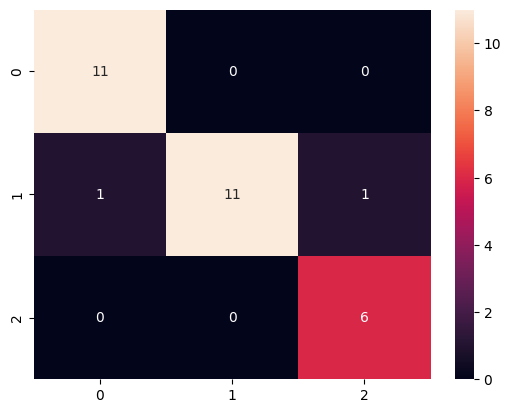

In [13]:
from sklearn import datasets
import numpy as np

# load iris dataset
iris = datasets.load_iris()
X=np.array(iris.data)
y = np.array(iris.target)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Build up the decision tree classifier
dt = DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train, y_train)

# Predict on testing data
y_pred = dt.predict(X_test)

# Print out the result
dt.print_tree(dt.tree)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, annot_kws={"size": 10})


acc = np.sum(y_test==y_pred)/len(y_pred)
print("Accuracy: {} %".format(round(acc*100),2))

Decision tree can also be apply to regression probelms, the differnce is that MSE is used to determine the best split,

$$MSE = \frac{1}{n} \Sigma_i^n {(y_i-\overline{y})^2}$$

where $\overline{y}$ is the mean of y in the group.

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple
from sklearn.model_selection import train_test_split

class RegressionTreeNode:
    def __init__(self, X, feature_idx, feature_val, parent = None):
        self.X = X
        self.feature_idx: int = feature_idx
        self.feature_val: float = feature_val
        self.parent: RegressionTreeNode = parent
        self.left: RegressionTreeNode = None
        self.right: RegressionTreeNode = None
        self.predict_val: float = None
    
    def update_left(self, left):
        self.left = left

    def update_right(self, right):
        self.right = right

class DecisionTreeRegressor:
    def __init__(self, max_depth: int = 6, min_samples_leaf: int = 1):
        """
        Args:
            max_depth (int): maximum depth of the tree
            min_samples_leaf (int): minimum number of samples required to be at a leaf node
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree: DecisionTreeRegressor = None

    def mse(self, y_left: np.array, y_right: np.array) -> Tuple[float, float]:
        """Implement the mse function
        Args:
            y_left (np.array): An array of y values in left group
            y_right (np.array): An array of y values in right group
        Returns:
            mes_left (float): The mse of the given y_left
            mes_right (float): The mse of the given y_right"""
        mes_left = np.mean([(y_left[i]-np.mean(y_left))**2 for i in range(len(y_left))])
        mes_right = np.mean([(y_right[i]-np.mean(y_right))**2 for i in range(len(y_right))])
        return mes_left, mes_right
    
    def split(self, X: np.array, y: np.array, feature_idx: int, feature_val: float) -> Tuple[np.array, np.array]:
        """Split the data into two group with the given feature and value
        Args:
            X (np.array): The input data
            y (np.array): The target labels
            feature_idx (int): The index of the feature to split
            feature_val (float): The value to split on
        Returns:
                X_left (np.array): The probability of each class in the left split data
                X_right (np.array): The probability of each class in the right split data"""
        x1 = X[X.T[feature_idx]<feature_val]
        x2 = X[X.T[feature_idx]>=feature_val]
        y1 = y[X.T[feature_idx]<feature_val]
        y2 = y[X.T[feature_idx]>=feature_val]

        return x1, x2, y1, y2


    def get_cost(self, y1, y2):
        """Calculate the cost of the split
        Args:
            y1 (np.array): The target labels in the left split
            y2 (np.array): The target labels in the right split
        Returns:
            cost (float): The cost of the split"""
        mse_left, mse_right = self.mse(y1, y2)
        return (len(y1)/(len(y1)+len(y2))) * mse_left + (len(y2)/(len(y1)+len(y2))) * mse_right


    def find_best_split(self, X: np.array, y: np.array) -> Tuple[int, float, float, np.array, np.array, np.array, np.array]:
        """Find the best split for the given data and criterion
        Args:
            X (np.array): The input data
            y (np.array): The target labels
        Returns:
            feature_idx (int): The index of the feature to split
            feature_val (float): The value to split on
            best_score (float): The best score of the split
            x1 (np.array): The left split data
            x2 (np.array): The right split data
            y1 (np.array): The left split target labels
            y2 (np.array): The right split target labels
            """
        n_features = X.shape[1]
        best_score = 10e+10
        flag = False
        for feature_idx in range(n_features):
            all_val = np.unique(X.T[feature_idx])
            val = np.unique([np.percentile(all_val, 20),np.percentile(all_val, 40),np.percentile(all_val, 60),
                             np.percentile(all_val, 80)])
            for feature_val in val:
                x1, x2, y1, y2 = self.split(X, y, feature_idx, feature_val)
                current_split = {'feature_idx': feature_idx, 'feature_val': feature_val, 
                                'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'best_score': best_score}
                score = self.get_cost(y1, y2)
                if score < best_score:
                    flag = True
                    best_score = score
                    best_split = current_split
        if flag:
            return best_split['feature_idx'], best_split['feature_val'], best_split['best_score'], \
                    best_split['x1'], best_split['x2'], best_split['y1'], best_split['y2']
        else:
            return current_split['feature_idx'], current_split['feature_val'], current_split['best_score'], \
                    current_split['x1'], current_split['x2'], current_split['y1'], current_split['y2']
    

    def fit(self, X: np.array, y: np.array, current_depth: int = 0, parent = None) -> RegressionTreeNode:
        """Build a decision tree for the given data
        Args:
            X (np.array): The input data
            max_depth (int): The maximum depth of the tree
        Returns:
            root (RegressionTreeNode): The root node of the decision tree"""
        
        self.total_nclasses = len(np.unique(y))
        

        if current_depth > self.max_depth:
            return None
        
        feature_idx, feature_val, best_score, x1, x2, y1, y2 = self.find_best_split(X, y)
        tree = RegressionTreeNode(X, feature_idx, feature_val, parent)
        tree.predict_values = np.mean(y)
        
        if len(x1) < self.min_samples_leaf or len(x2) < self.min_samples_leaf:
            self.tree = tree
            return self.tree
        #print(current_depth)
        current_depth += 1
        tree.left = (self.fit(x1, y1, current_depth, parent = tree))
        tree.right = (self.fit(x2, y2, current_depth, parent = tree))

        self.tree = tree
        return self.tree
    
    def predict(self, X: np.array) -> np.array:
        """Predict the class of the given input data
        Args:
            X (np.array): The input data
        Returns:
            predictions (np.array): The predicted class of the input data"""
        predictions = []
        for x in X:
            node = self.tree
            while node.left is not None and node.right is not None:
                if x[node.feature_idx] < node.feature_val:
                    node = node.left
                else:
                    node = node.right
            predictions.append(node.predict_values)
        return np.array(predictions)
    
    def print_tree(self, Node: RegressionTreeNode, depth: int = 0):
        """Print the decision tree
        Args:
            Node (RegressionTreeNode): The root node of the tree
            depth (int): The depth of the tree"""
        if depth == 0:
            Node = self.tree
        if Node is None:
            return
        print(' | '*depth,'-', Node.feature_idx, '<' , Node.predict_values)
        if Node.left is None and Node.right is None:
            print('   '*depth, '| - value :', np.argmax(Node.predict_values))
        self.print_tree(Node.left, depth+1)
        print(' | '*depth,'-', Node.feature_idx, '>=' , Node.predict_values)
        if Node.left is None and Node.right is None:
            print('   '*depth, '| - value: ', np.argmax(Node.predict_values))
        self.print_tree(Node.right, depth+1)

In [15]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

diabate = load_diabetes()
X = diabate.data
y = diabate.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

dtr = DecisionTreeRegressor(max_depth = 3)

rt = dtr.fit(X_train, y_train)

dtr.print_tree(rt)

y_pred = dtr.predict(X_test)

print('RMSE: ', np.sqrt(np.mean((y_test - y_pred) ** 2 )))

 - 8 < 153.37677053824362
 |  - 2 < 118.02564102564102
 |  |  - 8 < 99.41666666666667
 |  |  |  - 0 < 82.15686274509804
          | - value : 0
 |  |  |  - 0 >= 82.15686274509804
          | - value:  0
 |  |  - 8 >= 99.41666666666667
 |  |  |  - 2 < 110.28395061728395
          | - value : 0
 |  |  |  - 2 >= 110.28395061728395
          | - value:  0
 |  - 2 >= 118.02564102564102
 |  |  - 6 < 157.015873015873
 |  |  |  - 9 < 194.96
          | - value : 0
 |  |  |  - 9 >= 194.96
          | - value:  0
 |  |  - 6 >= 157.015873015873
 |  |  |  - 2 < 132.05263157894737
          | - value : 0
 |  |  |  - 2 >= 132.05263157894737
          | - value:  0
 - 8 >= 153.37677053824362
 |  - 2 < 197.00632911392404
 |  |  - 7 < 158.40579710144928
 |  |  |  - 8 < 132.59259259259258
          | - value : 0
 |  |  |  - 8 >= 132.59259259259258
          | - value:  0
 |  |  - 7 >= 158.40579710144928
 |  |  |  - 2 < 175.0
          | - value : 0
 |  |  |  - 2 >= 175.0
          | - value:  0
 |  - 2 

#### Reference

https://medium.com/@enozeren/building-a-decision-tree-from-scratch-324b9a5ed836

https://github.com/zotroneneis/machine_learning_basics/blob/master/decision_tree_regression.ipynb